# ML1 - Group 09

## Import / Install packages

In [249]:
!pip install dmba

In [250]:
# imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from dmba import classificationSummary
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, classification_report

# increase maximum columns to display
pd.set_option('display.max_columns', 200)

## Load Dataset

In [251]:
# impoart data
mci_df_src = pd.read_csv("Major_Crime_Indicators_Open_Data.csv")
print(mci_df_src.shape)
mci_df_src.head()

(323296, 31)


X          Y  OBJECTID EVENT_UNIQUE_ID             REPORT_DATE  \
0 -79.425896  43.757346         1  GO-20141262074  2014/01/01 05:00:00+00   
1 -79.350229  43.646293         2  GO-20141260701  2014/01/01 05:00:00+00   
2 -79.376497  43.666423         3  GO-20141260889  2014/01/01 05:00:00+00   
3 -85.488744   0.000000         4  GO-20141260973  2014/01/01 05:00:00+00   
4 -79.344839  43.678946         5  GO-20141261050  2014/01/01 05:00:00+00   

                 OCC_DATE  REPORT_YEAR REPORT_MONTH  REPORT_DAY  REPORT_DOY  \
0  1998/06/01 04:00:00+00         2014      January           1           1   
1  2014/01/01 05:00:00+00         2014      January           1           1   
2  2014/01/01 05:00:00+00         2014      January           1           1   
3  2014/01/01 05:00:00+00         2014      January           1           1   
4  2014/01/01 05:00:00+00         2014      January           1           1   

   REPORT_DOW  REPORT_HOUR  OCC_YEAR OCC_MONTH  OCC_DAY  OCC_DOY     OCC_DOW  \
0  Wednesday            12       NaN       NaN      NaN      NaN         NaN   
1  Wednesday             3    2014.0   January      1.0      1.0  Wednesday    
2  Wednesday             4    2014.0   January      1.0      1.0  Wednesday    
3  Wednesday             4    2014.0   January      1.0      1.0  Wednesday    
4  Wednesday             4    2014.0   January      1.0      1.0  Wednesday    

   OCC_HOUR DIVISION                                      LOCATION_TYPE  \
0        12      D32                   Apartment (Rooming House, Condo)   
1         3      D51  Commercial Dwelling Unit (Hotel, Motel, B & B,...   
2         4      D51                   Apartment (Rooming House, Condo)   
3         4      NSA  Streets, Roads, Highways (Bicycle Path, Privat...   
4         4      D54  Streets, Roads, Highways (Bicycle Path, Privat...   

  PREMISES_TYPE  UCR_CODE  UCR_EXT                      OFFENCE  \
0     Apartment      1480      110  Administering Noxious Thing   
1    Commercial      2120      200                          B&E   
2     Apartment      1430      100                      Assault   
3       Outside      2130      210                   Theft Over   
4       Outside      1430      100                      Assault   

      MCI_CATEGORY HOOD_158    NEIGHBOURHOOD_158 HOOD_140  \
0          Assault       38     Lansing-Westgate       38   
1  Break and Enter       70      South Riverdale       70   
2          Assault       74  North St.James Town       74   
3       Theft Over      NSA                  NSA      NSA   
4          Assault       69          Blake-Jones       66   

          NEIGHBOURHOOD_140  LONG_WGS84  LAT_WGS84  
0     Lansing-Westgate (38)  -79.425896  43.757346  
1      South Riverdale (70)  -79.350229  43.646293  
2  North St.James Town (74)  -79.376497  43.666423  
3                       NSA  -85.488744   0.000000  
4             Danforth (66)  -79.344839  43.678946

## Pre-processing

### Filter dataset - Reduce observation size
Use only year 2022 data.

In [252]:
# copy source dataframe, use original as backup
mci_df = mci_df_src.copy()

# format OCC_DATE to datetime
mci_df.OCC_DATE = pd.to_datetime(mci_df.OCC_DATE)

# filter data. Use only year 2022 data.
mci_df = mci_df[(mci_df.OCC_DATE.dt.year >= 2022)].reset_index(drop = True)

#display dataframe info - dimensions, columns, data types
mci_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40226 entries, 0 to 40225
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   X                  40226 non-null  float64            
 1   Y                  40226 non-null  float64            
 2   OBJECTID           40226 non-null  int64              
 3   EVENT_UNIQUE_ID    40226 non-null  object             
 4   REPORT_DATE        40226 non-null  object             
 5   OCC_DATE           40226 non-null  datetime64[ns, UTC]
 6   REPORT_YEAR        40226 non-null  int64              
 7   REPORT_MONTH       40226 non-null  object             
 8   REPORT_DAY         40226 non-null  int64              
 9   REPORT_DOY         40226 non-null  int64              
 10  REPORT_DOW         40226 non-null  object             
 11  REPORT_HOUR        40226 non-null  int64              
 12  OCC_YEAR           40226 non-null  float64    

### Drop columns
Remove column taht will not be used

In [253]:
# drop columns that will not be used
mci_df = mci_df.drop(
    [
    # not included on the data documentation
    'X','Y','OBJECTID'
    # we are not interested in offence report information
    ,'REPORT_DATE','REPORT_YEAR', 'REPORT_MONTH', 'REPORT_DAY', 'REPORT_DOY', 'REPORT_DOW','REPORT_HOUR'
    # we are not internested on other offence information
    ,'UCR_CODE','UCR_EXT','OFFENCE'
    # we are using the City of Toronto's new 158 neighbourhood structure
    ,'HOOD_140','NEIGHBOURHOOD_140'
    ]
    , axis=1)

# display updated dimensions
print(mci_df.shape)
# display head
mci_df.head()

(40226, 16)


EVENT_UNIQUE_ID                  OCC_DATE  OCC_YEAR OCC_MONTH  OCC_DAY  \
0     GO-20223706 2022-01-01 05:00:00+00:00    2022.0   January      1.0   
1     GO-20223965 2022-01-01 05:00:00+00:00    2022.0   January      1.0   
2     GO-20225063 2022-01-01 05:00:00+00:00    2022.0   January      1.0   
3     GO-20225063 2022-01-01 05:00:00+00:00    2022.0   January      1.0   
4     GO-20225063 2022-01-01 05:00:00+00:00    2022.0   January      1.0   

   OCC_DOY     OCC_DOW  OCC_HOUR DIVISION  \
0      1.0  Saturday          15      D55   
1      1.0  Saturday          14      D14   
2      1.0  Saturday          19      D53   
3      1.0  Saturday          19      D53   
4      1.0  Saturday          19      D53   

                                       LOCATION_TYPE PREMISES_TYPE  \
0                   Apartment (Rooming House, Condo)     Apartment   
1  Single Home, House (Attach Garage, Cottage, Mo...         House   
2                   Apartment (Rooming House, Condo)     Apartment   
3                   Apartment (Rooming House, Condo)     Apartment   
4                   Apartment (Rooming House, Condo)     Apartment   

  MCI_CATEGORY HOOD_158   NEIGHBOURHOOD_158  LONG_WGS84  LAT_WGS84  
0      Assault       44     Flemingdon Park  -79.326407  43.718945  
1      Assault      172  Dovercourt Village  -79.426608  43.670589  
2      Assault      100      Yonge-Eglinton  -79.400835  43.707754  
3      Assault      100      Yonge-Eglinton  -79.400835  43.707754  
4      Assault      100      Yonge-Eglinton  -79.400835  43.707754

### Check duplicates and missing values

In [254]:
# check missing values, drop if needed
mci_df.isnull().sum()

EVENT_UNIQUE_ID      0
OCC_DATE             0
OCC_YEAR             0
OCC_MONTH            0
OCC_DAY              0
OCC_DOY              0
OCC_DOW              0
OCC_HOUR             0
DIVISION             0
LOCATION_TYPE        0
PREMISES_TYPE        0
MCI_CATEGORY         0
HOOD_158             0
NEIGHBOURHOOD_158    0
LONG_WGS84           0
LAT_WGS84            0
dtype: int64

In [255]:
# Check duplicates, remove if needed
print(mci_df.duplicated().sum())
# remove duplicates
mci_df = mci_df.drop_duplicates(ignore_index = True).copy()
# display updated dimensions
print(mci_df.shape)
# display head
mci_df.head()

4363
(35863, 16)


EVENT_UNIQUE_ID                  OCC_DATE  OCC_YEAR OCC_MONTH  OCC_DAY  \
0     GO-20223706 2022-01-01 05:00:00+00:00    2022.0   January      1.0   
1     GO-20223965 2022-01-01 05:00:00+00:00    2022.0   January      1.0   
2     GO-20225063 2022-01-01 05:00:00+00:00    2022.0   January      1.0   
3      GO-2022644 2022-01-01 05:00:00+00:00    2022.0   January      1.0   
4     GO-20224580 2022-01-01 05:00:00+00:00    2022.0   January      1.0   

   OCC_DOY     OCC_DOW  OCC_HOUR DIVISION  \
0      1.0  Saturday          15      D55   
1      1.0  Saturday          14      D14   
2      1.0  Saturday          19      D53   
3      1.0  Saturday           1      D31   
4      1.0  Saturday          19      D43   

                                       LOCATION_TYPE PREMISES_TYPE  \
0                   Apartment (Rooming House, Condo)     Apartment   
1  Single Home, House (Attach Garage, Cottage, Mo...         House   
2                   Apartment (Rooming House, Condo)     Apartment   
3                                   Bar / Restaurant    Commercial   
4  Streets, Roads, Highways (Bicycle Path, Privat...       Outside   

  MCI_CATEGORY HOOD_158   NEIGHBOURHOOD_158  LONG_WGS84  LAT_WGS84  
0      Assault       44     Flemingdon Park  -79.326407  43.718945  
1      Assault      172  Dovercourt Village  -79.426608  43.670589  
2      Assault      100      Yonge-Eglinton  -79.400835  43.707754  
3      Assault       21       Humber Summit  -79.549072  43.750643  
4      Assault      136           West Hill  -79.199826  43.760005

### Format and transform

In [256]:
mci_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35863 entries, 0 to 35862
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   EVENT_UNIQUE_ID    35863 non-null  object             
 1   OCC_DATE           35863 non-null  datetime64[ns, UTC]
 2   OCC_YEAR           35863 non-null  float64            
 3   OCC_MONTH          35863 non-null  object             
 4   OCC_DAY            35863 non-null  float64            
 5   OCC_DOY            35863 non-null  float64            
 6   OCC_DOW            35863 non-null  object             
 7   OCC_HOUR           35863 non-null  int64              
 8   DIVISION           35863 non-null  object             
 9   LOCATION_TYPE      35863 non-null  object             
 10  PREMISES_TYPE      35863 non-null  object             
 11  MCI_CATEGORY       35863 non-null  object             
 12  HOOD_158           35863 non-null  object     

In [257]:
# new column with numeric values 
mci_df['OCC_MONTH_N'] = mci_df.OCC_DATE.dt.month
mci_df['OCC_DOW_N'] = mci_df.OCC_DATE.dt.day_of_week
# format to int
mci_df[['OCC_YEAR','OCC_DAY','OCC_DOY']] = mci_df[['OCC_YEAR','OCC_DAY','OCC_DOY']].astype(int)

# preview updates
mci_df[['OCC_DATE','OCC_MONTH','OCC_MONTH_N','OCC_DOW','OCC_DOW_N','OCC_YEAR','OCC_DAY','OCC_DOY','OCC_HOUR']].head()

OCC_DATE OCC_MONTH  OCC_MONTH_N     OCC_DOW  OCC_DOW_N  \
0 2022-01-01 05:00:00+00:00   January            1  Saturday            5   
1 2022-01-01 05:00:00+00:00   January            1  Saturday            5   
2 2022-01-01 05:00:00+00:00   January            1  Saturday            5   
3 2022-01-01 05:00:00+00:00   January            1  Saturday            5   
4 2022-01-01 05:00:00+00:00   January            1  Saturday            5   

   OCC_YEAR  OCC_DAY  OCC_DOY  OCC_HOUR  
0      2022        1        1        15  
1      2022        1        1        14  
2      2022        1        1        19  
3      2022        1        1         1  
4      2022        1        1        19

### Selecting predictors and target

In [258]:
mci_df.columns

Index(['EVENT_UNIQUE_ID', 'OCC_DATE', 'OCC_YEAR', 'OCC_MONTH', 'OCC_DAY',
       'OCC_DOY', 'OCC_DOW', 'OCC_HOUR', 'DIVISION', 'LOCATION_TYPE',
       'PREMISES_TYPE', 'MCI_CATEGORY', 'HOOD_158', 'NEIGHBOURHOOD_158',
       'LONG_WGS84', 'LAT_WGS84', 'OCC_MONTH_N', 'OCC_DOW_N'],
      dtype='object')

Columns/variables not used as predictors
* `EVENT_UNIQUE_ID`: unique identifier does not provide any meaningful information 
* `OCC_DATE`: we decided to use the breakdown values - Year, Day of Year, Month, Day of Week, Day, Hour  
* `OCC_MONTH`: we are using its numeric evquivalent OCC_MONTH_N  
* `OCC_DOW`: we are using its numeric evquivalent OCC_DOW_N  

In [259]:
# select predictors and target variables
predictors = ['OCC_YEAR',
    # numerical
    'OCC_DOY', 'OCC_MONTH_N', 'OCC_DAY', 'OCC_HOUR','OCC_DOW_N'
    ,'LONG_WGS84','LAT_WGS84'
    # categorical
    ,'DIVISION', 'LOCATION_TYPE','PREMISES_TYPE','HOOD_158'
    ]
target = 'MCI_CATEGORY'

In [260]:
# retain only the pre-selected columns
mci_df = mci_df[[target] + predictors]

# display updated dimensions
mci_df.shape

(35863, 13)

### Check categorical columns

In [261]:
categorical_cols = mci_df.select_dtypes(include='object').columns
categorical_cols

Index(['MCI_CATEGORY', 'DIVISION', 'LOCATION_TYPE', 'PREMISES_TYPE',
       'HOOD_158'],
      dtype='object')

In [262]:
# display unique values for each categorical variable
for col in categorical_cols:
    #unique_values.append(mci_df[f'{col}'].unique())
    unique_values = mci_df[f'{col}'].unique()
    print(f'---column name: {col}---')
    print(f'value count:{len(unique_values)}')
    print(f'values:{unique_values}')

---column name: MCI_CATEGORY---
value count:5
values:['Assault' 'Break and Enter' 'Auto Theft' 'Robbery' 'Theft Over']
---column name: DIVISION---
value count:17
values:['D55' 'D14' 'D53' 'D31' 'D43' 'D32' 'D23' 'D11' 'D13' 'D52' 'D12' 'D51'
 'D22' 'D41' 'D33' 'D42' 'NSA']
---column name: LOCATION_TYPE---
value count:51
values:['Apartment (Rooming House, Condo)'
 'Single Home, House (Attach Garage, Cottage, Mobile)' 'Bar / Restaurant'
 'Streets, Roads, Highways (Bicycle Path, Private Road)'
 "Other Non Commercial / Corporate Places (Non-Profit, Gov'T, Firehall)"
 'Commercial Dwelling Unit (Hotel, Motel, B & B, Short Term Rental)'
 'Construction Site (Warehouse, Trailer, Shed)'
 'Other Commercial / Corporate Places (For Profit, Warehouse, Corp. Bldg'
 'Gas Station (Self, Full, Attached Convenience)' 'Ttc Subway Station'
 'Homeless Shelter / Mission'
 'Parking Lots (Apt., Commercial Or Non-Commercial)'
 'Schools During Un-Supervised Activity' 'Convenience Stores' 'Go Station'
 'Ttc Bus' 

In [263]:
# summary stats
mci_df.describe()

OCC_YEAR       OCC_DOY   OCC_MONTH_N       OCC_DAY      OCC_HOUR  \
count   35863.0  35863.000000  35863.000000  35863.000000  35863.000000   
mean     2022.0    188.710147      6.720325     15.548169     12.585394   
std         0.0    102.819485      3.362585      8.847162      7.333283   
min      2022.0      1.000000      1.000000      1.000000      0.000000   
25%      2022.0    102.000000      4.000000      8.000000      6.000000   
50%      2022.0    190.000000      7.000000     16.000000     14.000000   
75%      2022.0    278.000000     10.000000     23.000000     19.000000   
max      2022.0    365.000000     12.000000     31.000000     23.000000   

          OCC_DOW_N    LONG_WGS84     LAT_WGS84  
count  35863.000000  35863.000000  35863.000000  
mean       2.988149    -79.486639     43.116999  
std        1.992149      0.708827      5.038174  
min        0.000000    -85.488744      0.000000  
25%        1.000000    -79.488550     43.659506  
50%        3.000000    -79.401773     43.698772  
75%        5.000000    -79.339537     43.749131  
max        6.000000    -78.828963     44.351392

### Visualize

In [264]:
#mci_df.MCI_CATEGORY.value_counts()
mci_category_counts = mci_df.groupby(target).size().reset_index(name='COUNT')
mci_category_counts

MCI_CATEGORY  COUNT
0          Assault  17619
1       Auto Theft   8705
2  Break and Enter   5961
3          Robbery   2205
4       Theft Over   1373

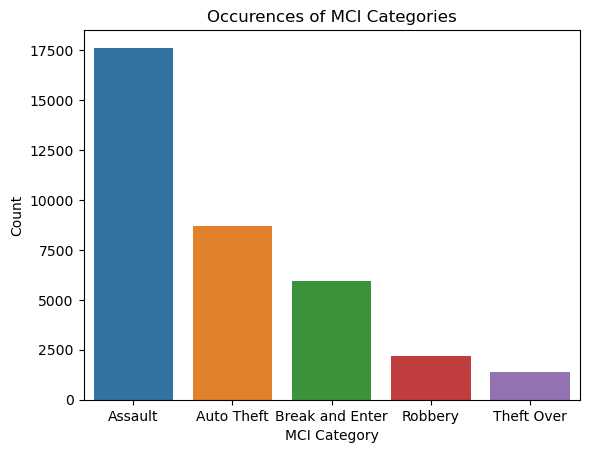

In [265]:
# plot target variable
ax = sns.barplot(data=mci_category_counts, x=target, y='COUNT')
ax.set_title('Occurences of MCI Categories')
ax.set_xlabel('MCI Category')
ax.set_ylabel('Count')
plt.show()

In [266]:
mci_df

MCI_CATEGORY  OCC_YEAR  OCC_DOY  OCC_MONTH_N  OCC_DAY  OCC_HOUR  \
0              Assault      2022        1            1        1        15   
1              Assault      2022        1            1        1        14   
2              Assault      2022        1            1        1        19   
3              Assault      2022        1            1        1         1   
4              Assault      2022        1            1        1        19   
...                ...       ...      ...          ...      ...       ...   
35858  Break and Enter      2022      356           12       22         8   
35859  Break and Enter      2022      365           12       31         3   
35860          Assault      2022      356           12       22        16   
35861          Assault      2022      365           12       31         4   
35862  Break and Enter      2022      365           12       31         4   

       OCC_DOW_N  LONG_WGS84  LAT_WGS84 DIVISION  \
0              5  -79.326407  43.718945      D55   
1              5  -79.426608  43.670589      D14   
2              5  -79.400835  43.707754      D53   
3              5  -79.549072  43.750643      D31   
4              5  -79.199826  43.760005      D43   
...          ...         ...        ...      ...   
35858          3  -79.301740  43.736102      D41   
35859          5  -79.258639  43.828794      D42   
35860          3  -79.425645  43.701404      D53   
35861          5  -79.385170  43.672134      D53   
35862          5  -79.248081  43.736690      D43   

                                           LOCATION_TYPE PREMISES_TYPE  \
0                       Apartment (Rooming House, Condo)     Apartment   
1      Single Home, House (Attach Garage, Cottage, Mo...         House   
2                       Apartment (Rooming House, Condo)     Apartment   
3                                       Bar / Restaurant    Commercial   
4      Streets, Roads, Highways (Bicycle Path, Privat...       Outside   
...                                                  ...           ...   
35858  Single Home, House (Attach Garage, Cottage, Mo...         House   
35859  Other Commercial / Corporate Places (For Profi...    Commercial   
35860                   Apartment (Rooming House, Condo)     Apartment   
35861                                 Convenience Stores    Commercial   
35862  Other Commercial / Corporate Places (For Profi...    Commercial   

      HOOD_158  
0           44  
1          172  
2          100  
3           21  
4          136  
...        ...  
35858      119  
35859      130  
35860      102  
35861       98  
35862      138  

[35863 rows x 13 columns]

In [267]:
# numeric - excluding log/lat
numeric_cols = mci_df.select_dtypes(include='int').columns
numeric_cols

Index(['OCC_YEAR', 'OCC_DOY', 'OCC_MONTH_N', 'OCC_DAY', 'OCC_HOUR',
       'OCC_DOW_N'],
      dtype='object')

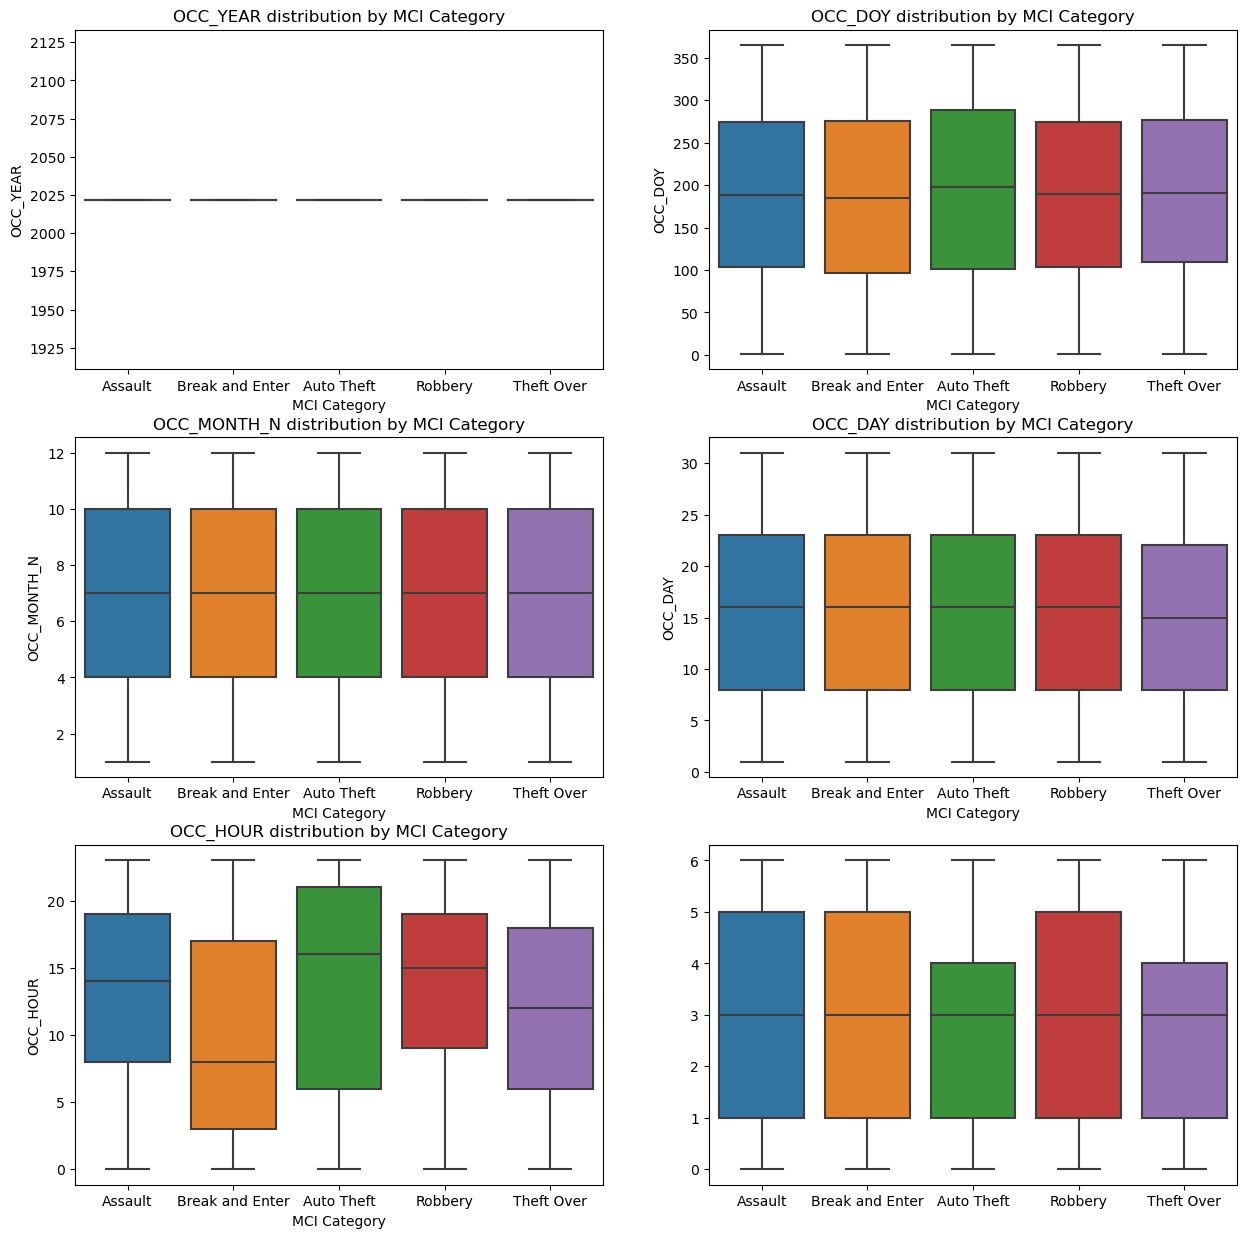

In [268]:
# Create a 3x3 grid of subplots
nrows = 3
ncols=2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
# plot numeric variables vs target
# remove year, since data is only 2022
axes_row = 0
axes_cols = 0
for col in numeric_cols:
    plot_axes =  axes[axes_row, axes_cols]
    sns.boxplot(x=target, y=f'{col}', data=mci_df, ax = plot_axes)
    plot_axes.set_title(f'{col} distribution by MCI Category')
    plot_axes.set_xlabel('MCI Category')
    plot_axes.set_ylabel(f'{col}')
    if axes_cols < (ncols-1):
        axes_cols += 1
    else:
        axes_cols = 0
        axes_row += 1
        
plt.title('')
plt.xlabel('')
plt.ylabel('')

# Add a title for the whole plot
plt.show()
    

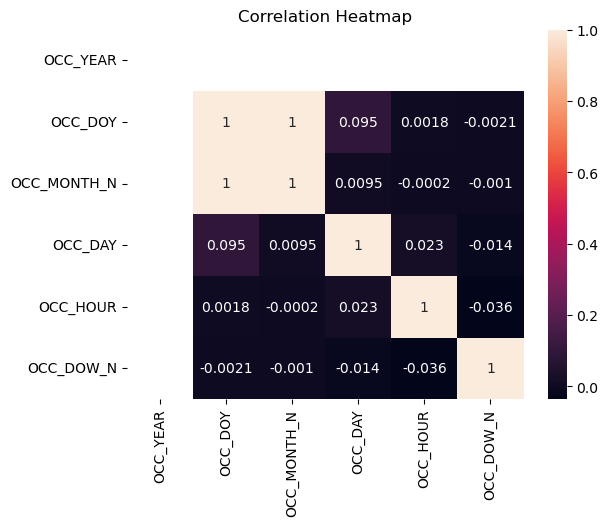

In [270]:
# check correlation for numerical predictors
corr = mci_df[numeric_cols].corr().round(4)
sns.heatmap(corr, annot=True)
plt.title('Correlation Heatmap')
plt.show()

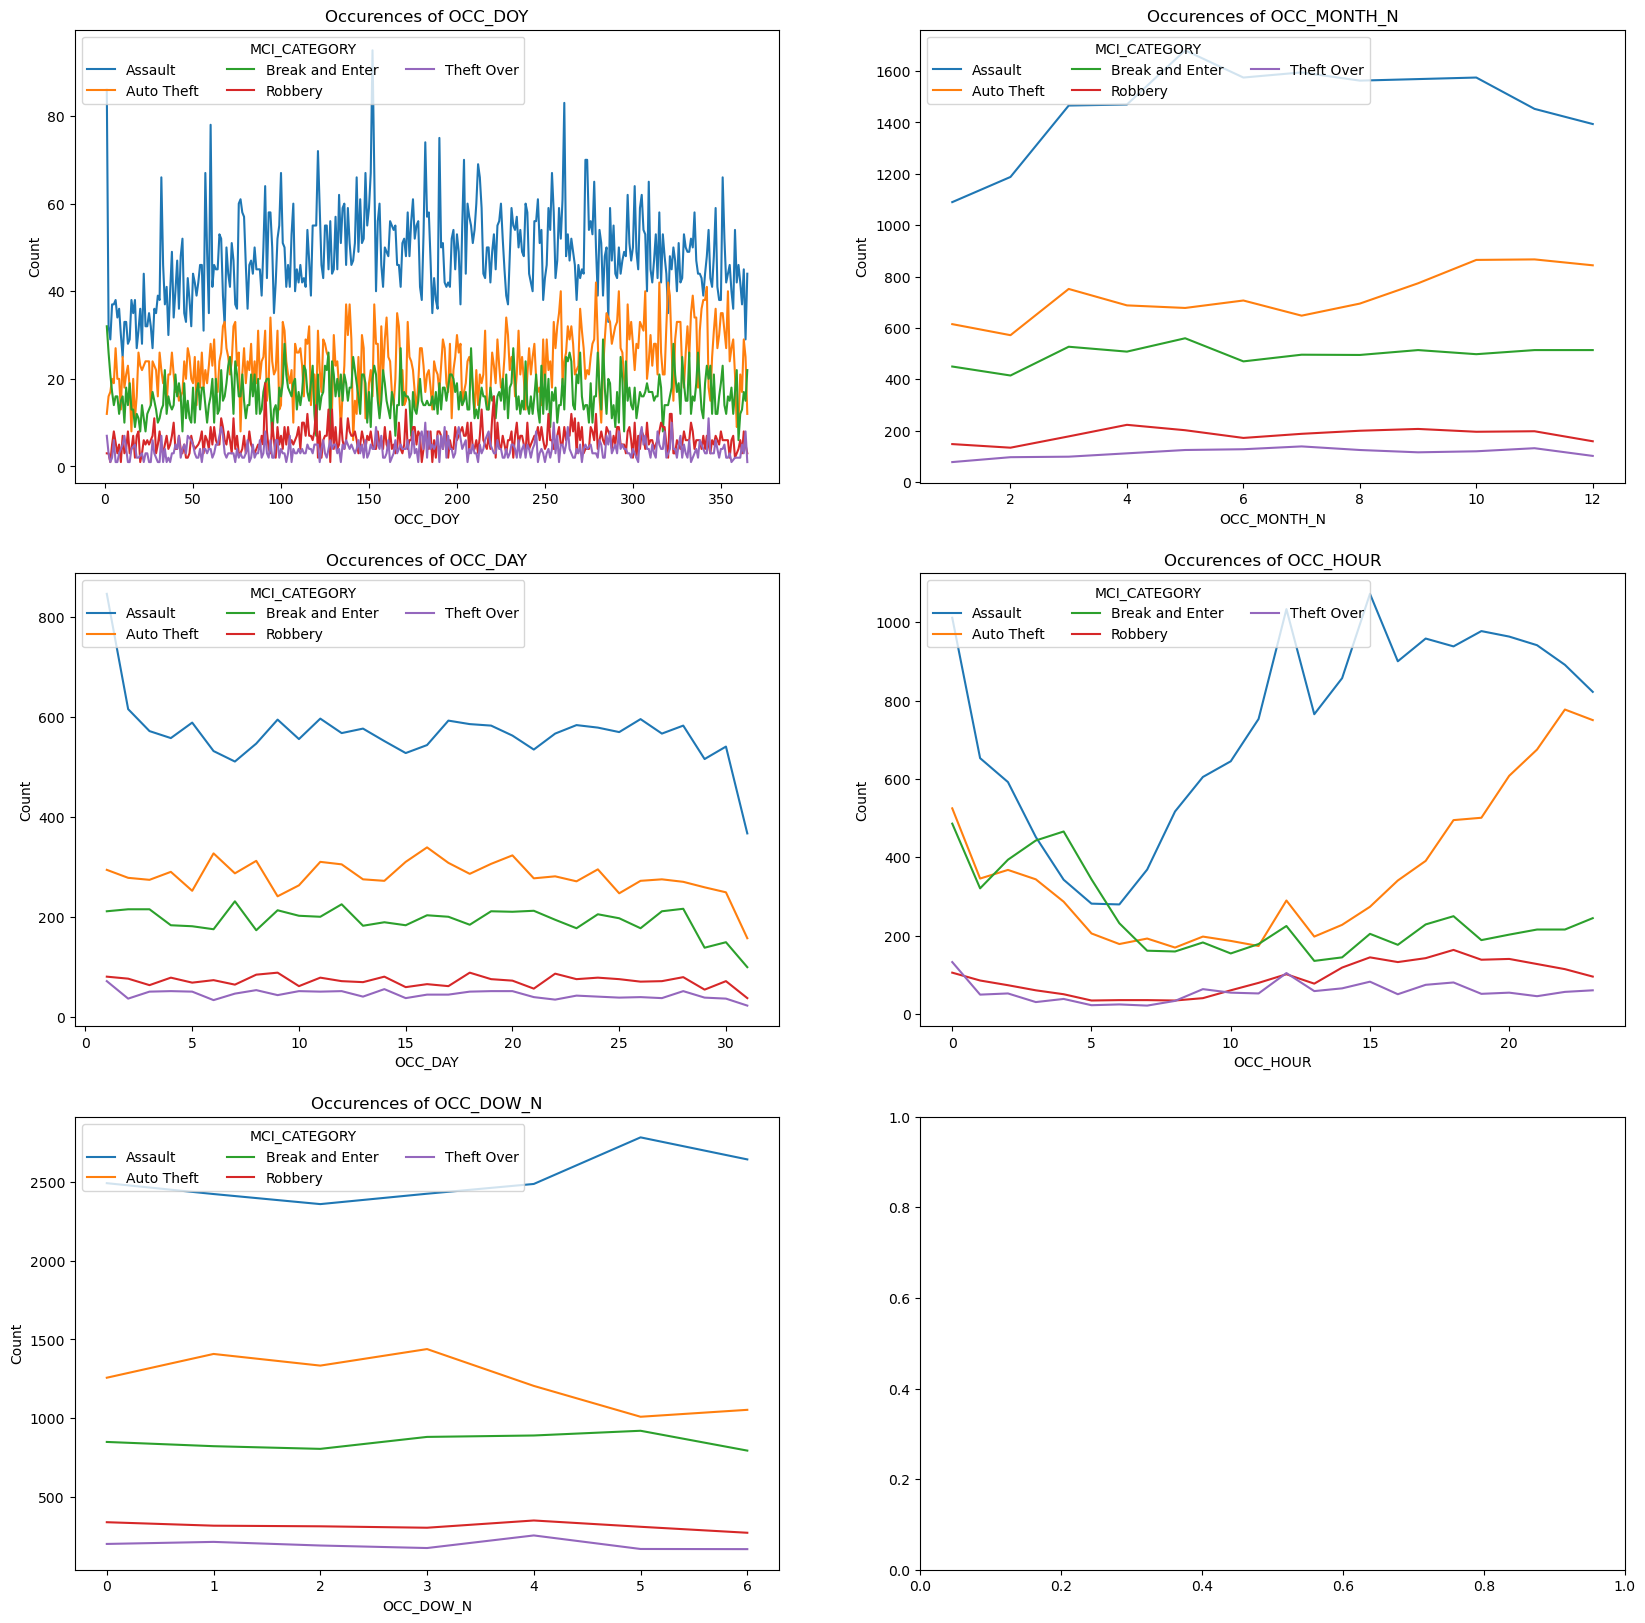

In [271]:
# time variables
time_cols = ['OCC_DOY', 'OCC_MONTH_N', 'OCC_DAY', 'OCC_HOUR', 'OCC_DOW_N']
# Create a 3x3 grid of subplots
nrows = 3
ncols=2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
# plot time  variables vs target
axes_row = 0
axes_cols = 0

count_col = 'COUNT'
for col in time_cols:
    # Group the data by MCI category and time column, and count the occurrences
    counts = mci_df.groupby([target, col]).size().reset_index(name=count_col)
    
    plot_axes =  axes[axes_row, axes_cols]
    # Create a line plot
    sns.lineplot(x=col, y=count_col, hue=target, data=counts, ax = plot_axes)
    plot_axes.set_title(f'Occurences of {col}')
    plot_axes.set_xlabel(col)
    plot_axes.set_ylabel('Count')
    plot_axes.legend(title=target, loc='upper left', ncol=3)
    if axes_cols < (ncols-1):
        axes_cols += 1
    else:
        axes_cols = 0
        axes_row += 1

plt.title('')
plt.xlabel('')
plt.ylabel('')

# Add a title for the whole plot
plt.show()       

In [272]:
counts = mci_df.groupby([target, 'LOCATION_TYPE']).size().reset_index(name=count_col)
counts.sort_values('COUNT', ascending = False).head(30)
counts['LOCATION_TYPE'].apply(lambda x: (x[0:25] + '..') if len(x)>25 else x )

0      Apartment (Rooming House,..
1      Bank And Other Financial ..
2                 Bar / Restaurant
3                      Cargo Train
4      Commercial Dwelling Unit ..
                  ...             
170                 Ttc Street Car
171             Ttc Subway Station
172               Ttc Subway Train
173        Universities / Colleges
174                        Unknown
Name: LOCATION_TYPE, Length: 175, dtype: object

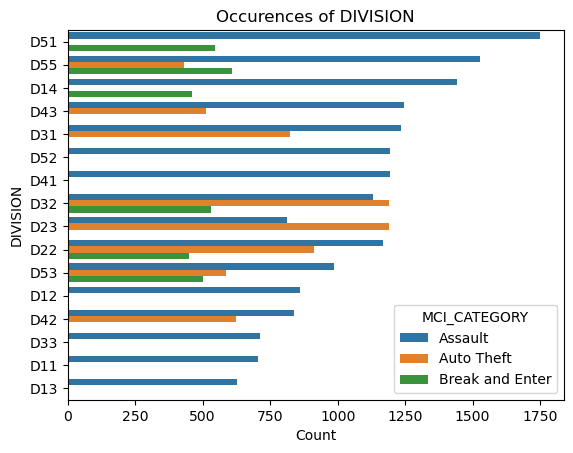

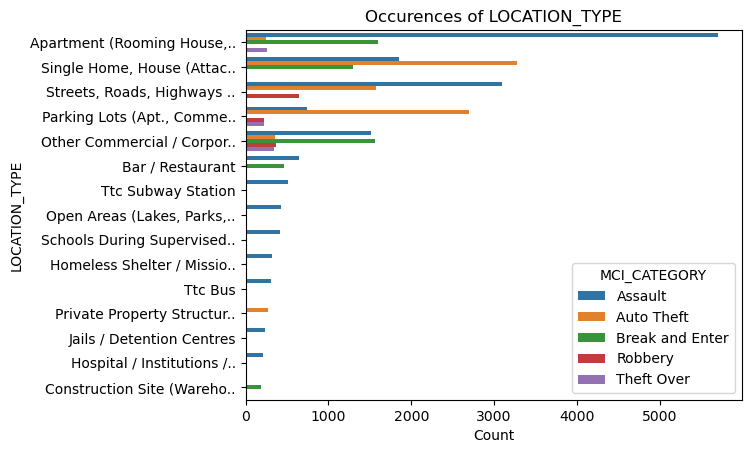

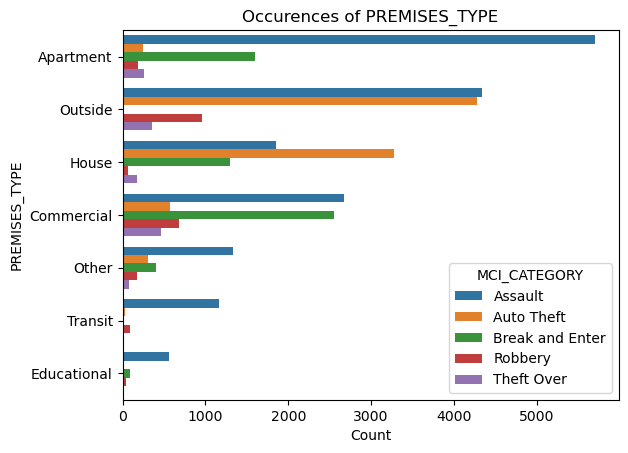

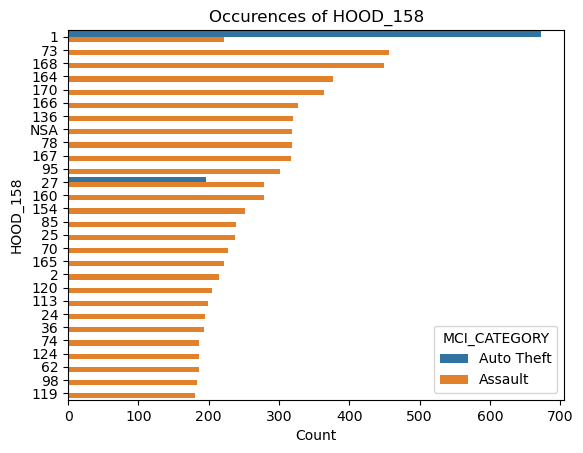

In [273]:
count_col = 'COUNT'
for col in categorical_cols[1:]:
    # Group the data by MCI category and time column, and count the occurrences
    counts = mci_df.groupby([target, col]).size().reset_index(name=count_col)
    # plot only top 25 counts
    counts = counts.sort_values('COUNT', ascending = False).head(30)
    # limit label disaply to 25 chracters
    counts[col] = counts[col].apply(lambda x: (x[0:25] + '..') if len(x)>25 else x )

    #plot_axes =  axes[axes_row, axes_cols]
    # Create a line plot
    sns.barplot(y=col, x=count_col, hue=target, data=counts)
    plt.title(f'Occurences of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.legend(title=target, loc='lower right')
    
    # Add a title for the whole plot
    plt.show()       

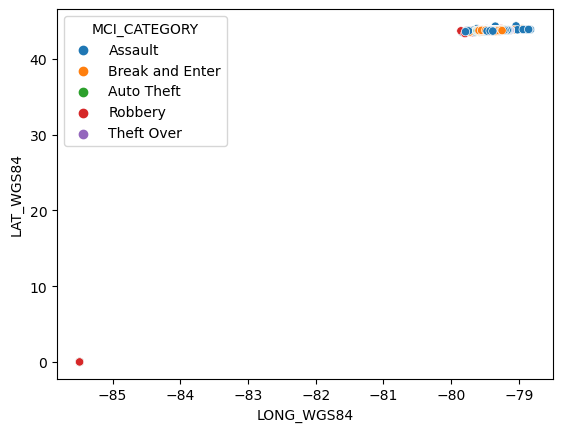

In [274]:
sns.scatterplot(x='LONG_WGS84', y='LAT_WGS84', hue='MCI_CATEGORY', data=mci_df)
plt.show()

In [275]:
mci_df[mci_df.LONG_WGS84 <-84][['LONG_WGS84','LAT_WGS84','MCI_CATEGORY', 'DIVISION', 'PREMISES_TYPE','LOCATION_TYPE']]

LONG_WGS84  LAT_WGS84     MCI_CATEGORY DIVISION PREMISES_TYPE  \
58     -85.488744        0.0          Assault      D11       Transit   
77     -85.488744        0.0  Break and Enter      D13         House   
194    -85.488744        0.0          Assault      D53    Commercial   
197    -85.488744        0.0          Assault      NSA       Outside   
230    -85.488744        0.0       Auto Theft      NSA       Outside   
...           ...        ...              ...      ...           ...   
35407  -85.488744        0.0       Auto Theft      D23       Outside   
35425  -85.488744        0.0          Assault      NSA     Apartment   
35495  -85.488744        0.0          Assault      NSA       Transit   
35576  -85.488744        0.0       Auto Theft      D23       Outside   
35630  -85.488744        0.0          Robbery      NSA       Outside   

                                           LOCATION_TYPE  
58                                               Ttc Bus  
77     Single Home, House (Attach Garage, Cottage, Mo...  
194    Other Commercial / Corporate Places (For Profi...  
197    Streets, Roads, Highways (Bicycle Path, Privat...  
230    Parking Lots (Apt., Commercial Or Non-Commercial)  
...                                                  ...  
35407  Parking Lots (Apt., Commercial Or Non-Commercial)  
35425                   Apartment (Rooming House, Condo)  
35495                                            Ttc Bus  
35576  Parking Lots (Apt., Commercial Or Non-Commercial)  
35630                  Open Areas (Lakes, Parks, Rivers)  

[483 rows x 6 columns]

In [276]:
log_lat_df = mci_df[mci_df.LONG_WGS84 >-84][['LONG_WGS84','LAT_WGS84','MCI_CATEGORY', 'DIVISION', 'PREMISES_TYPE','LOCATION_TYPE']]
log_lat_df

LONG_WGS84  LAT_WGS84     MCI_CATEGORY DIVISION PREMISES_TYPE  \
0      -79.326407  43.718945          Assault      D55     Apartment   
1      -79.426608  43.670589          Assault      D14         House   
2      -79.400835  43.707754          Assault      D53     Apartment   
3      -79.549072  43.750643          Assault      D31    Commercial   
4      -79.199826  43.760005          Assault      D43       Outside   
...           ...        ...              ...      ...           ...   
35858  -79.301740  43.736102  Break and Enter      D41         House   
35859  -79.258639  43.828794  Break and Enter      D42    Commercial   
35860  -79.425645  43.701404          Assault      D53     Apartment   
35861  -79.385170  43.672134          Assault      D53    Commercial   
35862  -79.248081  43.736690  Break and Enter      D43    Commercial   

                                           LOCATION_TYPE  
0                       Apartment (Rooming House, Condo)  
1      Single Home, House (Attach Garage, Cottage, Mo...  
2                       Apartment (Rooming House, Condo)  
3                                       Bar / Restaurant  
4      Streets, Roads, Highways (Bicycle Path, Privat...  
...                                                  ...  
35858  Single Home, House (Attach Garage, Cottage, Mo...  
35859  Other Commercial / Corporate Places (For Profi...  
35860                   Apartment (Rooming House, Condo)  
35861                                 Convenience Stores  
35862  Other Commercial / Corporate Places (For Profi...  

[35380 rows x 6 columns]

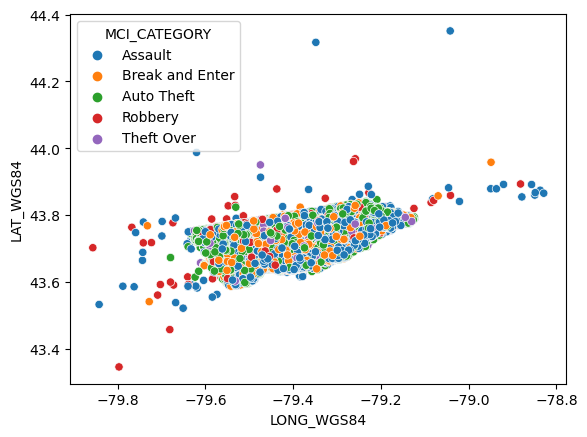

In [277]:
sns.scatterplot(x='LONG_WGS84', y='LAT_WGS84', hue='MCI_CATEGORY', data=log_lat_df)
plt.show()

### Finalize predictors

In [279]:
predictors + [target]

['OCC_YEAR',
 'OCC_DOY',
 'OCC_MONTH_N',
 'OCC_DAY',
 'OCC_HOUR',
 'OCC_DOW_N',
 'LONG_WGS84',
 'LAT_WGS84',
 'DIVISION',
 'LOCATION_TYPE',
 'PREMISES_TYPE',
 'HOOD_158',
 'MCI_CATEGORY']

In [280]:
# remove columns
updated_predictors  = predictors.copy()
# removed the longitude and latitude values
# we wanted to have clear input values - like the time variables and categorized location variables.
updated_predictors.remove('LONG_WGS84')
updated_predictors.remove('LAT_WGS84')
updated_predictors

['OCC_YEAR',
 'OCC_DOY',
 'OCC_MONTH_N',
 'OCC_DAY',
 'OCC_HOUR',
 'OCC_DOW_N',
 'DIVISION',
 'LOCATION_TYPE',
 'PREMISES_TYPE',
 'HOOD_158']

### Prepare data for modelling

In [281]:
# create new dataframe from selected predictors and target columns
new_mci_df = mci_df[updated_predictors + [target]].copy()
print(new_mci_df.shape)
new_mci_df.head()

(35863, 11)


OCC_YEAR  OCC_DOY  OCC_MONTH_N  OCC_DAY  OCC_HOUR  OCC_DOW_N DIVISION  \
0      2022        1            1        1        15          5      D55   
1      2022        1            1        1        14          5      D14   
2      2022        1            1        1        19          5      D53   
3      2022        1            1        1         1          5      D31   
4      2022        1            1        1        19          5      D43   

                                       LOCATION_TYPE PREMISES_TYPE HOOD_158  \
0                   Apartment (Rooming House, Condo)     Apartment       44   
1  Single Home, House (Attach Garage, Cottage, Mo...         House      172   
2                   Apartment (Rooming House, Condo)     Apartment      100   
3                                   Bar / Restaurant    Commercial       21   
4  Streets, Roads, Highways (Bicycle Path, Privat...       Outside      136   

  MCI_CATEGORY  
0      Assault  
1      Assault  
2      Assault  
3      Assault  
4      Assault

In [282]:
# check columns information
new_mci_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35863 entries, 0 to 35862
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OCC_YEAR       35863 non-null  int32 
 1   OCC_DOY        35863 non-null  int32 
 2   OCC_MONTH_N    35863 non-null  int64 
 3   OCC_DAY        35863 non-null  int32 
 4   OCC_HOUR       35863 non-null  int64 
 5   OCC_DOW_N      35863 non-null  int64 
 6   DIVISION       35863 non-null  object
 7   LOCATION_TYPE  35863 non-null  object
 8   PREMISES_TYPE  35863 non-null  object
 9   HOOD_158       35863 non-null  object
 10  MCI_CATEGORY   35863 non-null  object
dtypes: int32(3), int64(3), object(5)
memory usage: 2.6+ MB


In [283]:
# Check duplicates, remove if needed
new_mci_df = new_mci_df.drop_duplicates(ignore_index = True)
new_mci_df.duplicated().sum()

0

### Numerical representation for categorical variables
Using two methods `get_dummies()` and `LabelEncoder()`.

In [284]:
# get updated categorical columns, excluding the target variable
categorical_cols = new_mci_df.drop(columns = target, axis =1).select_dtypes(include = 'object').columns
categorical_cols

Index(['DIVISION', 'LOCATION_TYPE', 'PREMISES_TYPE', 'HOOD_158'], dtype='object')

#### get_dummies

In [285]:
# one-hot encoding categorical variables
# This creates new columns with binary value (0/1),  per category or unique value
# dropping the first category to avoid perfect multicollinearity 
dummies_mci_df = pd.get_dummies(new_mci_df
                                , columns = categorical_cols
                                , drop_first = True # dropping the first category
                               )
print(dummies_mci_df.shape)
dummies_mci_df.head()

(35479, 237)


OCC_YEAR  OCC_DOY  OCC_MONTH_N  OCC_DAY  OCC_HOUR  OCC_DOW_N MCI_CATEGORY  \
0      2022        1            1        1        15          5      Assault   
1      2022        1            1        1        14          5      Assault   
2      2022        1            1        1        19          5      Assault   
3      2022        1            1        1         1          5      Assault   
4      2022        1            1        1        19          5      Assault   

   DIVISION_D12  DIVISION_D13  DIVISION_D14  DIVISION_D22  DIVISION_D23  \
0             0             0             0             0             0   
1             0             0             1             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   DIVISION_D31  DIVISION_D32  DIVISION_D33  DIVISION_D41  DIVISION_D42  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             1             0             0             0             0   
4             0             0             0             0             0   

   DIVISION_D43  DIVISION_D51  DIVISION_D52  DIVISION_D53  DIVISION_D55  \
0             0             0             0             0             1   
1             0             0             0             0             0   
2             0             0             0             1             0   
3             0             0             0             0             0   
4             1             0             0             0             0   

   DIVISION_NSA  \
0             0   
1             0   
2             0   
3             0   
4             0   

   LOCATION_TYPE_Bank And Other Financial Institutions (Money Mart, Tsx)  \
0                                                  0                       
1                                                  0                       
2                                                  0                       
3                                                  0                       
4                                                  0                       

   LOCATION_TYPE_Bar / Restaurant  LOCATION_TYPE_Cargo Train  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               1                          0   
4                               0                          0   

   LOCATION_TYPE_Commercial Dwelling Unit (Hotel, Motel, B & B, Short Term Rental)  \
0                                                  0                                 
1                                                  0                                 
2                                                  0                                 
3                                                  0                                 
4                                                  0                                 

   LOCATION_TYPE_Community Group Home  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   

   LOCATION_TYPE_Construction Site (Warehouse, Trailer, Shed)  \
0                                                  0            
1                                                  0            
2                                                  0            
3                                                  0            
4                                                  0            

   LOCATION_TYPE_Convenience Stores  \
0                 

#### LabelEncoder

In [286]:
# convert new columns with numerical representation of the categorical data
# we then drop the original columns
from sklearn.preprocessing import LabelEncoder

labelled_mci_df = new_mci_df.copy()
for e_col in categorical_cols:
    le = LabelEncoder()
    labelled_mci_df[f'{e_col}_le'] = le.fit_transform(labelled_mci_df[e_col])
    
# drop the original columns
labelled_mci_df = labelled_mci_df.drop(columns = categorical_cols, axis =1)

print(labelled_mci_df.shape)
print(labelled_mci_df.columns[0:20])
labelled_mci_df

(35479, 11)
Index(['OCC_YEAR', 'OCC_DOY', 'OCC_MONTH_N', 'OCC_DAY', 'OCC_HOUR',
       'OCC_DOW_N', 'MCI_CATEGORY', 'DIVISION_le', 'LOCATION_TYPE_le',
       'PREMISES_TYPE_le', 'HOOD_158_le'],
      dtype='object')


OCC_YEAR  OCC_DOY  OCC_MONTH_N  OCC_DAY  OCC_HOUR  OCC_DOW_N  \
0          2022        1            1        1        15          5   
1          2022        1            1        1        14          5   
2          2022        1            1        1        19          5   
3          2022        1            1        1         1          5   
4          2022        1            1        1        19          5   
...         ...      ...          ...      ...       ...        ...   
35474      2022      356           12       22         8          3   
35475      2022      365           12       31         3          5   
35476      2022      356           12       22        16          3   
35477      2022      365           12       31         4          5   
35478      2022      365           12       31         4          5   

          MCI_CATEGORY  DIVISION_le  LOCATION_TYPE_le  PREMISES_TYPE_le  \
0              Assault           15                 0                 0   
1              Assault            3                36                 3   
2              Assault           14                 0                 0   
3              Assault            6                 2                 1   
4              Assault           11                37                 5   
...                ...          ...               ...               ...   
35474  Break and Enter            9                36                 3   
35475  Break and Enter           10                20                 1   
35476          Assault           14                 0                 0   
35477          Assault           14                 7                 1   
35478  Break and Enter           11                20                 1   

       HOOD_158_le  
0              104  
1               73  
2                2  
3               80  
4               36  
...            ...  
35474           20  
35475           32  
35476            4  
35477          156  
35478           37  

[35479 rows x 11 columns]

In [287]:
new_mci_df.drop(columns = target, axis =1).select_dtypes(include = 'object').columns
new_mci_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35479 entries, 0 to 35478
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OCC_YEAR       35479 non-null  int32 
 1   OCC_DOY        35479 non-null  int32 
 2   OCC_MONTH_N    35479 non-null  int64 
 3   OCC_DAY        35479 non-null  int32 
 4   OCC_HOUR       35479 non-null  int64 
 5   OCC_DOW_N      35479 non-null  int64 
 6   DIVISION       35479 non-null  object
 7   LOCATION_TYPE  35479 non-null  object
 8   PREMISES_TYPE  35479 non-null  object
 9   HOOD_158       35479 non-null  object
 10  MCI_CATEGORY   35479 non-null  object
dtypes: int32(3), int64(3), object(5)
memory usage: 2.6+ MB


### Prepare for ML modelling


In [288]:
scale_features = [
                'OCC_YEAR'
                ,'OCC_DOY'
                ,'OCC_MONTH_N' 
                ,'OCC_DAY'
                ,'OCC_HOUR'
                ,'OCC_DOW_N'   
                #, 'LONG_WGS84', 'LAT_WGS84'
               ]
drop_features = [target]
print('scale_features:', scale_features)
print('drop_features:',drop_features)

scale_features: ['OCC_YEAR', 'OCC_DOY', 'OCC_MONTH_N', 'OCC_DAY', 'OCC_HOUR', 'OCC_DOW_N']
drop_features: ['MCI_CATEGORY']


## Build ML Model
Test 5 Machine Learning algorithms to create a model that best acheives our objective
1. Linear Regression
2. K-Nearest Neighbors (k-NN)
3. Naive Bayes Classifier
4. Classification And Regression Trees (CART)
5. LogisticRegression


In [289]:
# get unique values of target variable.
# will be used to label confusion matrix
labels = new_mci_df.MCI_CATEGORY.unique()
labels

array(['Assault', 'Break and Enter', 'Auto Theft', 'Robbery',
       'Theft Over'], dtype=object)

### 1. Linear Regression

In [290]:
target

'MCI_CATEGORY'

In [291]:
# Convert the target categorical column into numeric column
lr_dummies_mci_df = dummies_mci_df.copy()
mapping = {'Assault': 5
           , 'Break and Enter': 4
           , 'Auto Theft': 3
           , 'Robbery': 2
           ,'Theft Over': 1
          }
lr_dummies_mci_df['MCI_CATEGORY_ENCODED'] = lr_dummies_mci_df['MCI_CATEGORY'].map(mapping)
lr_dummies_mci_df[['MCI_CATEGORY','MCI_CATEGORY_ENCODED']]

MCI_CATEGORY  MCI_CATEGORY_ENCODED
0              Assault                     5
1              Assault                     5
2              Assault                     5
3              Assault                     5
4              Assault                     5
...                ...                   ...
35474  Break and Enter                     4
35475  Break and Enter                     4
35476          Assault                     5
35477          Assault                     5
35478  Break and Enter                     4

[35479 rows x 2 columns]

In [292]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr_target = 'MCI_CATEGORY_ENCODED'
lr_drop_features = drop_features + [lr_target]

df = lr_dummies_mci_df.copy()
# Split the data into training and testing sets
X = df.drop(columns=lr_drop_features, axis=1)
y = df[lr_target]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
params = {}

### Scale the features using StandardScaler
scaler = StandardScaler()
cols_to_scale = scale_features
train_X[cols_to_scale] = scaler.fit_transform(train_X[cols_to_scale])
test_X[cols_to_scale] = scaler.transform(test_X[cols_to_scale])

### relevant run info
print('relevant run info')
print('target:', target)
print('MCI_CATEGORY:', lr_dummies_mci_df[lr_target].unique())
print('drop_features:', lr_drop_features)
print('scale_features:', scale_features)
print('param:', params)
print('-----')

model_lr = LinearRegression()

model_lr.fit(train_X, train_y)
y_pred = model_lr.predict(test_X)

# Calculate and print the mean squared error of the model
mse = mean_squared_error(test_y, y_pred)
print(f"Mean squared error: {mse:.2f}")
mse = mean_squared_error(test_y, np.round(y_pred).astype(int))
print(f"Mean squared error: {mse:.2f}")
mse = mean_squared_error(test_y, np.ceil(y_pred).astype(int))
print(f"Mean squared error: {mse:.2f}")
mse = mean_squared_error(test_y, np.floor(y_pred).astype(int))
print(f"Mean squared error: {mse:.2f}")

# Calculate and print the R-squared value of the model
r_squared = model_lr.score(test_X, test_y)
print(f"R-squared value: {r_squared:.2f}")

# training confusion matrix
classificationSummary(train_y, np.round(model_lr.predict(train_X)).astype(int), class_names = labels)

relevant run info
target: MCI_CATEGORY
MCI_CATEGORY: [5 4 3 2 1]
drop_features: ['MCI_CATEGORY', 'MCI_CATEGORY_ENCODED']
scale_features: ['OCC_YEAR', 'OCC_DOY', 'OCC_MONTH_N', 'OCC_DAY', 'OCC_HOUR', 'OCC_DOW_N']
param: {}
-----
Mean squared error: 178224033126697888.00
Mean squared error: 1949698156666668.75
Mean squared error: 1949698156666668.75
Mean squared error: 1949698156666668.75
R-squared value: -136526664513978496.00
Confusion Matrix (Accuracy 0.4038)

                Prediction
         Actual         Assault Break and Enter      Auto Theft         Robbery      Theft Over
        Assault               0               4             256             701             141
Break and Enter               0               7             358            1184             220
     Auto Theft               0               0            3030            3793             108
        Robbery               0               5             390            3394             860
     Theft Over            

In [293]:
# validation confusion matrix - test using ceiling
y_ceil_pred = np.ceil(model_lr.predict(test_X)).astype(int)
# limit values between 1 to 5. values lower than 1 will be set to 1. while values greater than 5 will be as 5.
y_ceil_pred = np.clip(y_ceil_pred, 1, 5)
classificationSummary(test_y, y_ceil_pred, class_names = labels)
# validation confusion matrix - test using floor
y_floorl_pred = np.floor(model_lr.predict(test_X)).astype(int)
y_floorl_pred = np.clip(y_floorl_pred, 1, 5)
classificationSummary(test_y, y_floorl_pred, class_names = labels)

Confusion Matrix (Accuracy 0.4559)

                Prediction
         Actual         Assault Break and Enter      Auto Theft         Robbery      Theft Over
        Assault               0               0              10             172              81
Break and Enter               0               0              35             194             195
     Auto Theft               0               0             123            1374             195
        Robbery               0               0              18             654             532
     Theft Over               3               0              20            1032            2458
Confusion Matrix (Accuracy 0.2845)

                Prediction
         Actual         Assault Break and Enter      Auto Theft         Robbery      Theft Over
        Assault               0              10             172              81               0
Break and Enter               0              35             194             194               1
     Auto 

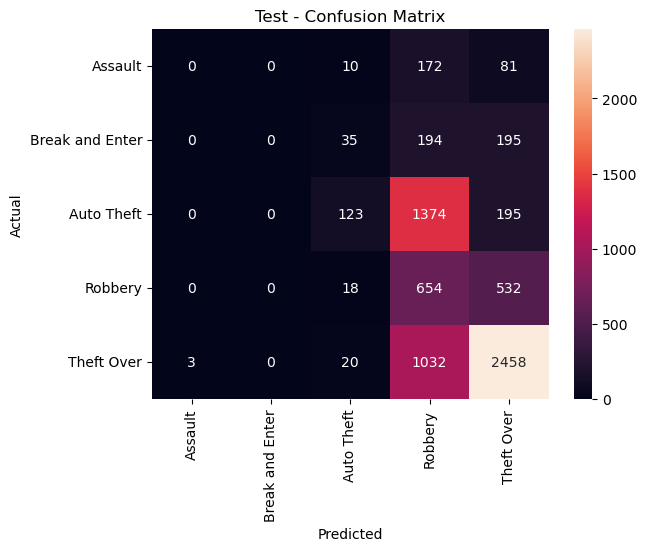

In [294]:
# Create a confusion matrix
cm = confusion_matrix(test_y, y_ceil_pred)
# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test - Confusion Matrix')
plt.show()

### 2. K-Nearest Neighbors (k-NN)

In [295]:
%%time
from sklearn.neighbors import KNeighborsClassifier

df = dummies_mci_df.copy()
# Split the data into training and testing sets
X = df.drop(columns=drop_features, axis=1)
y = df[target]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
params = {}

### Scale the features using StandardScaler
scaler = StandardScaler()
cols_to_scale = scale_features
train_X[cols_to_scale] = scaler.fit_transform(train_X[cols_to_scale])
test_X[cols_to_scale] = scaler.transform(test_X[cols_to_scale])

params = {'n_neighbors': 57}

### relevant run info
print('relevant run info')
print('target:', target)
print('MCI_CATEGORY:', dummies_mci_df.MCI_CATEGORY.unique())
print('drop_features:', drop_features)
print('scale_features:', scale_features)
print('param:', params)
print('-----')

# define model
model_knn = KNeighborsClassifier(**params)

# KNN model
model_knn.fit(train_X, train_y)
y_train_pred = model_knn.predict(train_X)
y_test_pred = model_knn.predict(test_X)
accuracy = accuracy_score(test_y, y_test_pred)
print("KNN accuracy:", accuracy)

# training confusion matrix
classificationSummary(train_y, y_train_pred, class_names = labels)
# validation confusion matrix
classificationSummary(test_y, y_test_pred, class_names = labels)


relevant run info
target: MCI_CATEGORY
MCI_CATEGORY: ['Assault' 'Break and Enter' 'Auto Theft' 'Robbery' 'Theft Over']
drop_features: ['MCI_CATEGORY']
scale_features: ['OCC_YEAR', 'OCC_DOY', 'OCC_MONTH_N', 'OCC_DAY', 'OCC_HOUR', 'OCC_DOW_N']
param: {'n_neighbors': 57}
-----


C:\Users\premn\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\premn\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

KNN accuracy: 0.6351465614430665
Confusion Matrix (Accuracy 0.6421)

                Prediction
         Actual         Assault Break and Enter      Auto Theft         Robbery      Theft Over
        Assault           12126            1489             317               0               0
Break and Enter            1974            4812             145               0               0
     Auto Theft            2743             624            1282               0               0
        Robbery            1406             274              83               6               0
     Theft Over             721             290              91               0               0
Confusion Matrix (Accuracy 0.6351)

                Prediction
         Actual         Assault Break and Enter      Auto Theft         Robbery      Theft Over
        Assault            2996             426              91               0               0
Break and Enter             486            1174              32          

In [296]:
# Evaluate the performance of the model on the training data
print("Training data performance:")
print(classification_report(train_y, y_train_pred))

# Evaluate the performance of the model on the validation data
print("Validation data performance:")
print(classification_report(test_y, y_test_pred))

Training data performance:


C:\Users\premn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\premn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\premn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

        Assault       0.64      0.87      0.74     13932
     Auto Theft       0.64      0.69      0.67      6931
Break and Enter       0.67      0.28      0.39      4649
        Robbery       1.00      0.00      0.01      1769
     Theft Over       0.00      0.00      0.00      1102

       accuracy                           0.64     28383
      macro avg       0.59      0.37      0.36     28383
   weighted avg       0.64      0.64      0.59     28383

Validation data performance:
                 precision    recall  f1-score   support

        Assault       0.64      0.85      0.73      3513
     Auto Theft       0.62      0.69      0.65      1692
Break and Enter       0.67      0.28      0.39      1204
        Robbery       1.00      0.00      0.00       424
     Theft Over       0.00      0.00      0.00       263

       accuracy                           0.64      7096
      macro avg       0.59      0.37      0.36      70

C:\Users\premn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\premn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\premn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


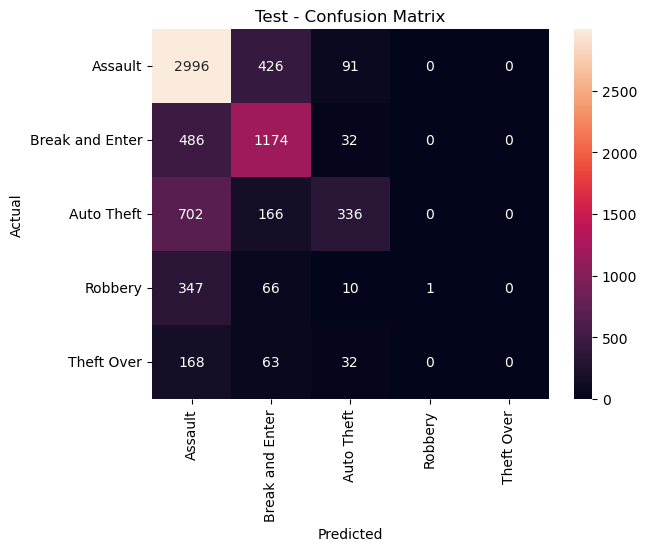

In [297]:
# Create a confusion matrix
cm = confusion_matrix(test_y, y_test_pred)
# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test - Confusion Matrix')
plt.show()

### 3. Naive Bayes Classifier

In [298]:
from sklearn.naive_bayes import MultinomialNB

df = dummies_mci_df.copy()
# Split the data into training and testing sets
X = df.drop(columns=drop_features, axis=1)
y = df[target]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
params = {}

#scaler = StandardScaler()
#cols_to_scale = scale_features
#train_X[cols_to_scale] = scaler.fit_transform(train_X[cols_to_scale])
#test_X[cols_to_scale] = scaler.transform(test_X[cols_to_scale])

params = {'alpha': 0.01}
### relevant run info
print('relevant run info')
print('target:', target)
print('MCI_CATEGORY:', dummies_mci_df.MCI_CATEGORY.unique())
print('drop_features:', drop_features)
print('scale_features:', scale_features)
print('param:', params)
print('-----')

model_nb = MultinomialNB(**params)

model_nb.fit(train_X, train_y);

relevant run info
target: MCI_CATEGORY
MCI_CATEGORY: ['Assault' 'Break and Enter' 'Auto Theft' 'Robbery' 'Theft Over']
drop_features: ['MCI_CATEGORY']
scale_features: ['OCC_YEAR', 'OCC_DOY', 'OCC_MONTH_N', 'OCC_DAY', 'OCC_HOUR', 'OCC_DOW_N']
param: {'alpha': 0.01}
-----


In [299]:
# predict probabilities
predProb_train = model_nb.predict_proba(train_X)
predProb_valid = model_nb.predict_proba(test_X)

# predict MCI category (shows the category instead of probability by selecting the category with highest probability)
y_train_pred =  model_nb.predict(train_X)
y_valid_pred =  model_nb.predict(test_X)

print(y_valid_pred)

#Confusion matrix
classificationSummary(train_y, y_train_pred, class_names = labels)
#Confusion matrix
classificationSummary(test_y, y_valid_pred, class_names = labels)

['Auto Theft' 'Break and Enter' 'Auto Theft' ... 'Break and Enter'
 'Break and Enter' 'Auto Theft']
Confusion Matrix (Accuracy 0.4883)

                Prediction
         Actual         Assault Break and Enter      Auto Theft         Robbery      Theft Over
        Assault            7275            3665            2738             130             124
Break and Enter            1715            3957            1076             154              29
     Auto Theft             959            1137            2388              39             126
        Robbery             766             453             346             177              27
     Theft Over             320             362             338              19              63
Confusion Matrix (Accuracy 0.4868)

                Prediction
         Actual         Assault Break and Enter      Auto Theft         Robbery      Theft Over
        Assault            1847             933             669              41              23
Break 

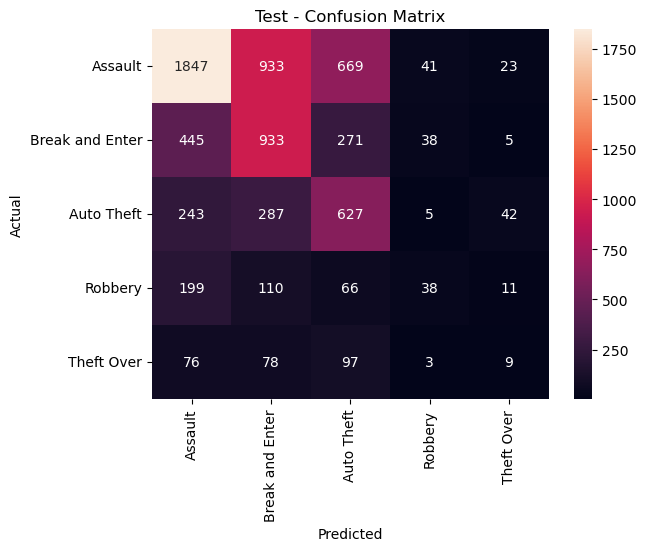

In [300]:
# Create a confusion matrix
cm = confusion_matrix(test_y, y_valid_pred)
# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test - Confusion Matrix')
plt.show()

### 4. Classification And Regression Trees (CART)

In [301]:
from sklearn.tree import DecisionTreeClassifier 

# Select input and output. Training and validation datasets.
X = new_mci_df.drop(columns=[target])
y = new_mci_df[target]

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=42)

# check dimension of partitioned data
print("train_X: ", train_X.shape)
print("valid_X: ", valid_X.shape)
print("train_y: ", train_y.shape)
print("valid_y: ", valid_y.shape)

train_X:  (28383, 10)
valid_X:  (7096, 10)
train_y:  (28383,)
valid_y:  (7096,)


In [302]:
trainData = pd.concat([train_X, train_y], axis=1)
ValidData = pd.concat([valid_X, valid_y], axis=1)
trainData.head()

OCC_YEAR  OCC_DOY  OCC_MONTH_N  OCC_DAY  OCC_HOUR  OCC_DOW_N DIVISION  \
24641      2022      263            9       20         1          1      D32   
16435      2022      180            6       29        22          2      D32   
3710       2022       51            2       20        13          6      D22   
24866      2022      265            9       22         0          3      D42   
13075      2022      147            5       27         6          4      D51   

                                           LOCATION_TYPE PREMISES_TYPE  \
24641                   Apartment (Rooming House, Condo)     Apartment   
16435  Single Home, House (Attach Garage, Cottage, Mo...         House   
3710                                             Ttc Bus       Transit   
24866  Hospital / Institutions / Medical Facilities (...         Other   
13075  Hospital / Institutions / Medical Facilities (...         Other   

      HOOD_158     MCI_CATEGORY  
24641       37       Theft Over  
16435      152       Auto Theft  
3710       159          Assault  
24866      148          Assault  
13075       72  Break and Enter

In [303]:
ValidData.head()

OCC_YEAR  OCC_DOY  OCC_MONTH_N  OCC_DAY  OCC_HOUR  OCC_DOW_N DIVISION  \
27470      2022      289           10       16        23          6      D12   
4641       2022       44            2       13         0          6      D22   
21082      2022      229            8       17        18          2      D23   
9642       2022      114            4       24         3          6      D52   
9026       2022      106            4       16        15          5      D55   

                                           LOCATION_TYPE PREMISES_TYPE  \
27470  Single Home, House (Attach Garage, Cottage, Mo...         House   
4641   Single Home, House (Attach Garage, Cottage, Mo...         House   
21082  Single Home, House (Attach Garage, Cottage, Mo...         House   
9642                                    Bar / Restaurant    Commercial   
9026   Parking Lots (Apt., Commercial Or Non-Commercial)       Outside   

      HOOD_158 MCI_CATEGORY  
27470      113   Auto Theft  
4641       160   Auto Theft  
21082        1      Assault  
9642        78      Assault  
9026        69   Auto Theft

In [304]:
trainData['Numerical_PREMISES_TYPE'], _ = pd.factorize(trainData['PREMISES_TYPE'])
New_TrainData = trainData[['OCC_HOUR','Numerical_PREMISES_TYPE','MCI_CATEGORY']].copy()
New_TrainData.head()

OCC_HOUR  Numerical_PREMISES_TYPE     MCI_CATEGORY
24641         1                        0       Theft Over
16435        22                        1       Auto Theft
3710         13                        2          Assault
24866         0                        3          Assault
13075         6                        3  Break and Enter

In [305]:
ValidData['Numerical_PREMISES_TYPE'], _ = pd.factorize(ValidData['PREMISES_TYPE'])
New_ValidData = ValidData[['OCC_HOUR','Numerical_PREMISES_TYPE','MCI_CATEGORY']].copy()
New_ValidData.head()

OCC_HOUR  Numerical_PREMISES_TYPE MCI_CATEGORY
27470        23                        0   Auto Theft
4641          0                        0   Auto Theft
21082        18                        0      Assault
9642          3                        1      Assault
9026         15                        2   Auto Theft

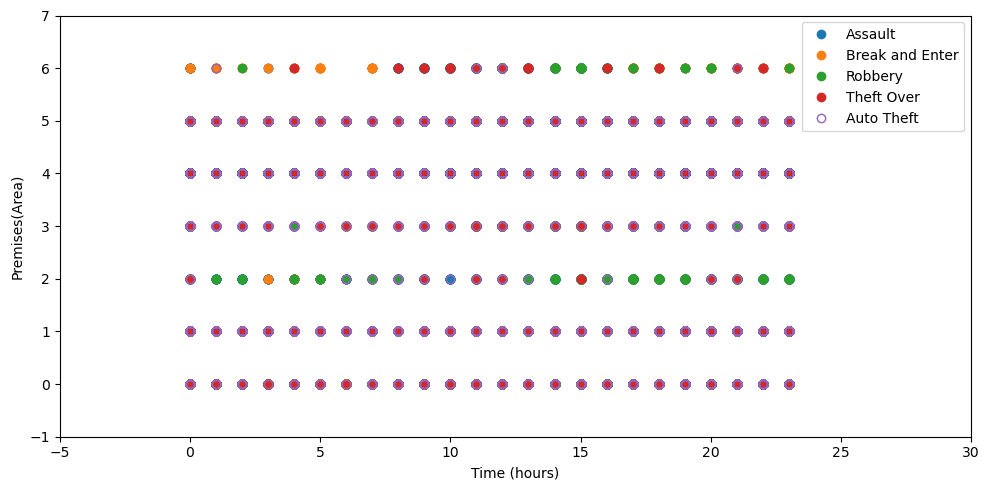

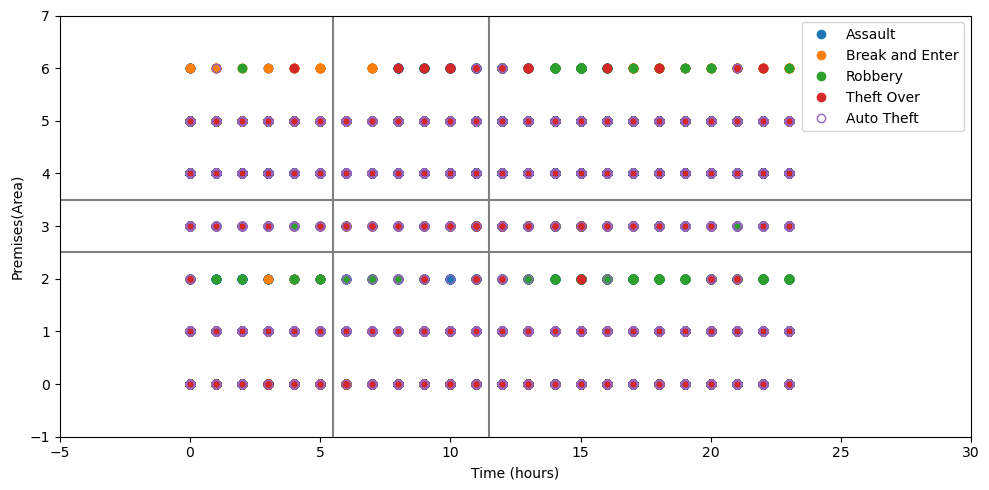

In [306]:
def basePlot (ax):
    New_TrainData.loc[New_TrainData.MCI_CATEGORY =='Assault'].plot(x= 'OCC_HOUR', y='Numerical_PREMISES_TYPE', style='o',
                                                           markerfacecolor ='C0', markeredgecolor ='C0', ax=ax)
    
    New_TrainData.loc[New_TrainData.MCI_CATEGORY =='Break and Enter'].plot(x='OCC_HOUR', y= 'Numerical_PREMISES_TYPE', style='o',
                                                            markerfacecolor ='C1', markeredgecolor ='C1',ax=ax)
    
    New_TrainData.loc[New_TrainData.MCI_CATEGORY =='Robbery'].plot( x='OCC_HOUR', y= 'Numerical_PREMISES_TYPE', style='o',
                                                           markerfacecolor ='C2', markeredgecolor ='C2', ax=ax)
    
    New_TrainData.loc[New_TrainData.MCI_CATEGORY =='Theft Over'].plot( x='OCC_HOUR', y= 'Numerical_PREMISES_TYPE', style='o',
                                                            markerfacecolor ='C3', markeredgecolor ='C3', ax=ax)
    
    New_TrainData.loc[New_TrainData.MCI_CATEGORY =='Auto Theft'].plot( x='OCC_HOUR', y= 'Numerical_PREMISES_TYPE', style='o',
                                                            markerfacecolor ='none', markeredgecolor ='C4', ax=ax)
    ax.legend(["Assault", "Break and Enter","Robbery","Theft Over","Auto Theft"]);
    ax.set_xlim(-5,30)
    ax.set_ylim(-1, 7) 
    ax.set_xlabel('Time (hours)') 
    ax.set_ylabel('Premises(Area)') 
    return ax
fig, ax = plt.subplots(figsize=(10, 5)) 
ax = basePlot(ax)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax = basePlot(ax) 
x0 = 11.5
y1 = 2.5
x1 = 5.5
y2 = 3.5
ax.plot((x0, x0), (-1,7), color='grey')
ax.plot((30 , -5), (y1 , y1 ), color='grey')
ax.plot((x1, x1), (-1,7), color='grey')
ax.plot((30 , -5), (y2 , y2 ), color='grey')
plt.tight_layout()
plt.show()


In [307]:
!pip install pydotplus 

In [308]:
from sklearn import tree
from dmba import plotDecisionTree
from IPython.display import Image
import pydotplus

New_TrainData

OCC_HOUR  Numerical_PREMISES_TYPE     MCI_CATEGORY
24641         1                        0       Theft Over
16435        22                        1       Auto Theft
3710         13                        2          Assault
24866         0                        3          Assault
13075         6                        3  Break and Enter
...         ...                      ...              ...
16850        23                        4       Theft Over
6265          0                        3  Break and Enter
11284         4                        5          Robbery
860          19                        1          Robbery
15795        12                        6       Auto Theft

[28383 rows x 3 columns]


(process:41008): GLib-GIO-WARNING **: 00:48:29.637: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.15.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs

(process:41008): GLib-GIO-WARNING **: 00:48:29.731: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2302.20.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs



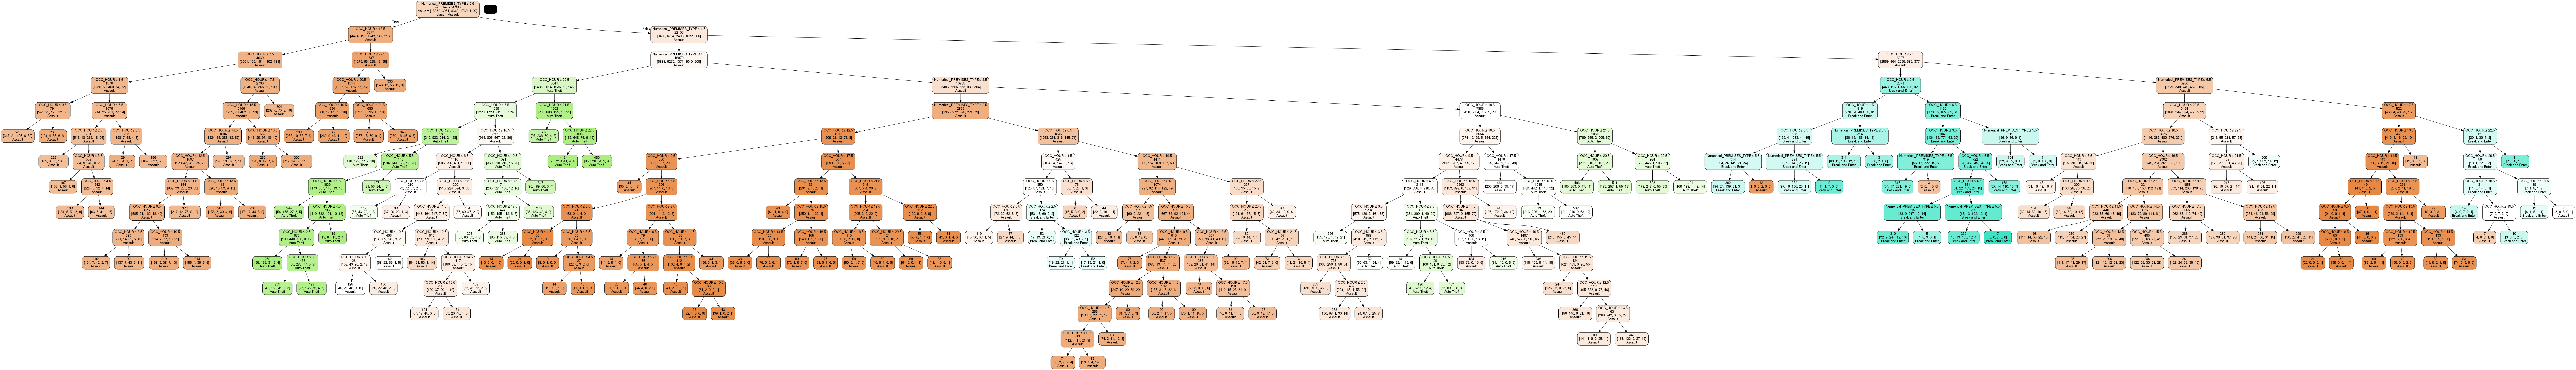

In [309]:
classTree = DecisionTreeClassifier(random_state=0, max_depth=15) 
classTree.fit(New_TrainData.drop(columns=['MCI_CATEGORY']), New_TrainData['MCI_CATEGORY'])
plotDecisionTree(classTree, feature_names=New_TrainData.columns[:2], class_names=classTree.classes_)

In [310]:
from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree as a DOT file
dot_data = export_graphviz(classTree, out_file=None,
                           feature_names=New_TrainData.columns[:2],
                           class_names=classTree.classes_,
                           filled=True, rounded=True,
                           special_characters=True
                          )
graph = graphviz.Source(dot_data)

# Save the decision tree as a PNG file
graph.format = 'png'
graph.render('classTree')


(process:20404): GLib-GIO-WARNING **: 00:48:40.269: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.15.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs

(process:20404): GLib-GIO-WARNING **: 00:48:40.354: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2302.20.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs


'classTree.png'

In [311]:
#model_dtc.fit(train_X, train_y)
# Predict the test set
y_pred_train = classTree.predict(New_TrainData.drop(columns=['MCI_CATEGORY']))
# Calculate the accuracy score of the classifier
accuracy_train = accuracy_score(New_TrainData['MCI_CATEGORY'], y_pred_train)
print('Accuracy:', accuracy_train)

# training confusion matrix
classificationSummary(train_y, classTree.predict(New_TrainData.drop(columns=['MCI_CATEGORY'])), class_names=labels)


Accuracy: 0.5847162033611669
Confusion Matrix (Accuracy 0.5847)

                Prediction
         Actual         Assault Break and Enter      Auto Theft         Robbery      Theft Over
        Assault           10813            2545             574               0               0
Break and Enter            2434            4314             183               0               0
     Auto Theft            2560             620            1469               0               0
        Robbery            1144             483             142               0               0
     Theft Over             770             223             109               0               0


In [312]:
#model_dtc.fit(train_X, train_y)
# Predict the Valid set
y_pred_val = classTree.predict(New_ValidData.drop(columns=['MCI_CATEGORY']))
# Calculate the accuracy score of the classifier
accuracy_val = accuracy_score(New_ValidData['MCI_CATEGORY'], y_pred_val)
print('Accuracy:', accuracy_val)

# Validation confusion matrix
classificationSummary(valid_y, classTree.predict(New_ValidData.drop(columns=['MCI_CATEGORY'])), class_names=labels)


Accuracy: 0.43320180383314544
Confusion Matrix (Accuracy 0.4332)

                Prediction
         Actual         Assault Break and Enter      Auto Theft         Robbery      Theft Over
        Assault            2921             418             174               0               0
Break and Enter            1586              97               9               0               0
     Auto Theft             626             522              56               0               0
        Robbery             333              83               8               0               0
     Theft Over             190              66               7               0               0


### 5. Logistic Regression

In [313]:
%%time
from sklearn.linear_model import LogisticRegression

#df = labelled_mci_df.copy()
df = dummies_mci_df.copy()
# Split the data into training and testing sets
X = df.drop(columns=drop_features, axis=1)
y = df[target]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
params = {}

### Scale the features using StandardScaler
scaler = StandardScaler()
cols_to_scale = scale_features
train_X[cols_to_scale] = scaler.fit_transform(train_X[cols_to_scale])
test_X[cols_to_scale] = scaler.transform(test_X[cols_to_scale])

# paramters
params = {'solver': 'liblinear', 'penalty':'l2', 'max_iter': 1500, 'random_state':42}

### relevant run info
print('relevant run info')
print('target:', target)
print('MCI_CATEGORY:', dummies_mci_df.MCI_CATEGORY.unique())
print('drop_features:', drop_features)
print('scale_features:', scale_features)
print('param:', params)
print('-----')

# define model
model_log_r = LogisticRegression(**params)
model_log_r.fit(train_X, train_y)
# training confusion matrix
classificationSummary(train_y, model_log_r.predict(train_X), class_names = labels)
# validation confusion matrix
y_pred =model_log_r.predict(test_X)
classificationSummary(test_y, y_pred, class_names = labels)

relevant run info
target: MCI_CATEGORY
MCI_CATEGORY: ['Assault' 'Break and Enter' 'Auto Theft' 'Robbery' 'Theft Over']
drop_features: ['MCI_CATEGORY']
scale_features: ['OCC_YEAR', 'OCC_DOY', 'OCC_MONTH_N', 'OCC_DAY', 'OCC_HOUR', 'OCC_DOW_N']
param: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1500, 'random_state': 42}
-----
Confusion Matrix (Accuracy 0.6368)

                Prediction
         Actual         Assault Break and Enter      Auto Theft         Robbery      Theft Over
        Assault           11435            1816             633              48               0
Break and Enter            1641            5069             218               3               0
     Auto Theft            2362             844            1400              43               0
        Robbery            1150             278             170             171               0
     Theft Over             579             326             184              13               0
Confusion Matrix (Accuracy 

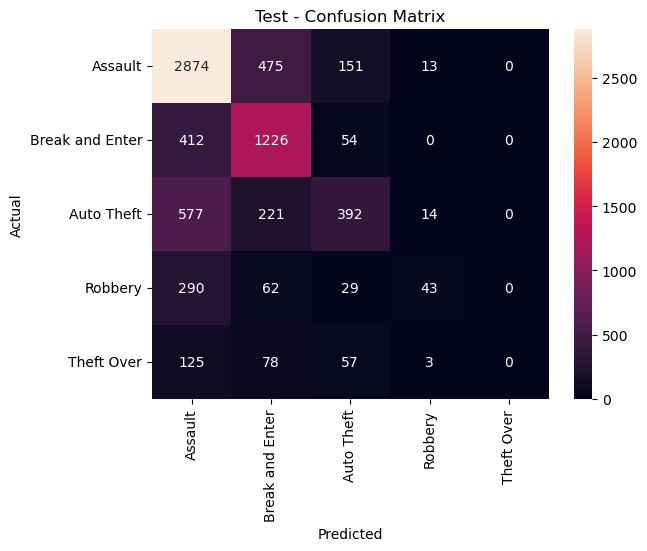

In [314]:
# Create a confusion matrix
cm = confusion_matrix(test_y, y_pred)
# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test - Confusion Matrix')
plt.show()